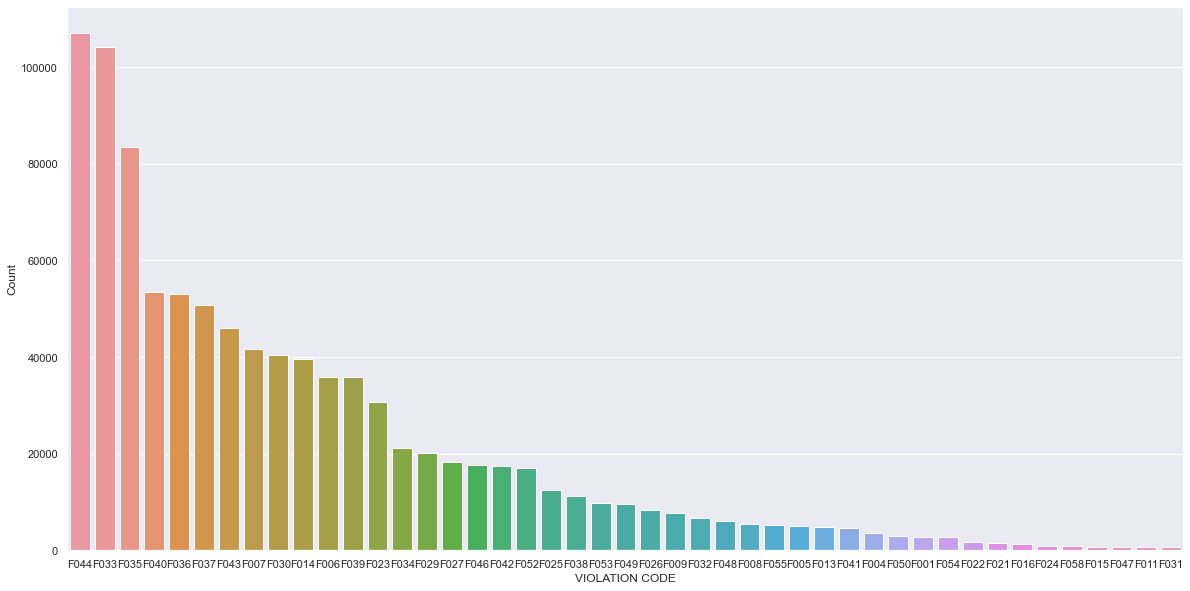

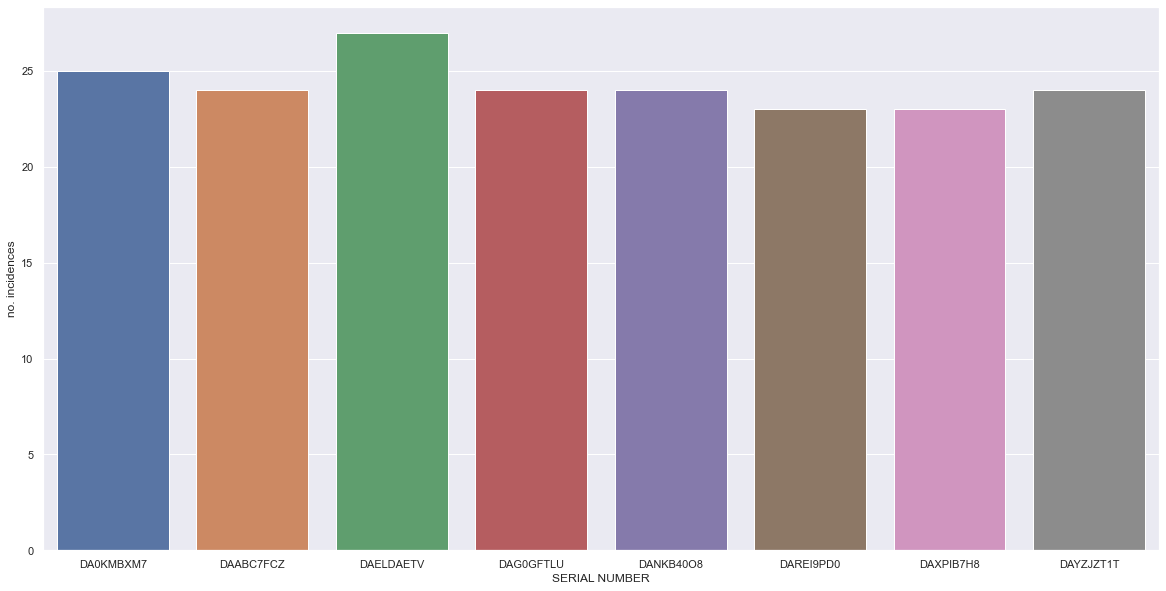

In [3]:
import tkinter as tk
from tkinter import *
from tkinter import ttk, messagebox, filedialog
import pandas as pd
import csv
import json
from pymongo import MongoClient
import gridfs
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2


root = tk.Tk()
root.pack_propagate(False)
root.geometry('800x800')
#first lay out the containers
#this fr1 is for overview
fr1 = tk.LabelFrame(root, text='View file')
fr1.place(height = 300, width = 800)
#fr2 to open file
fr2 = tk.LabelFrame(root, text='1. Open file')
fr2.place(height = 100, width = 320, relx = 0, rely = 0.4)
#fr3 to clean file
fr3 = tk.LabelFrame(root, text='2. Clean file')
fr3.place(height = 100, width = 320, relx = 0.6, rely = 0.4)
#fr4 to convert and upload to MongoDB
fr4 = tk.LabelFrame(root, text='3. Convert to JSON and upload to MongoDB')
fr4.place(height = 100, width = 320, relx = 0, rely = 0.7)
#fr5 to visulaise data in graphs
fr5 = tk.LabelFrame(root, text='4. Calculate averages, show graphs')
fr5.place(height = 100, width = 320, relx = 0.6, rely = 0.7)


#next make clickable buttons
button1 = tk.Button(fr2, text='Browse files...', command = lambda: File_xpl())
button1.place(relx=0.2, rely=0.5)

button2 = tk.Button(fr2, text='View file', command = lambda: Load_csv_file())
button2.place(relx=0.6, rely=0.5)

button3 = tk.Button(fr3, text='Clean data', command = lambda: Clean_data()) 
button3.place(relx=0.4, rely=0.5)

button4 = tk.Button(fr4, text='Convert and save to JSON', command = lambda: Convert_data()) 
button4.place(relx=0.01, rely=0.5)

button5 = tk.Button(fr4, text='Upload to MongoDB', command = lambda: Upload_data()) 
button5.place(relx=0.6, rely=0.5)

button6 = tk.Button(fr5, text='Calculate averages', command = lambda: Averages()) 
button6.place(relx=0.1, rely=0.5)
              
button7 = tk.Button(fr5, text='Show graph', command = lambda: Graphs()) 
button7.place(relx=0.5, rely=0.5)

#use labels to show def state
label_file = ttk.Label(fr2, text='Please choose a file.')
label_file.place(relx=0.1, rely=0.1)

label_file2 = ttk.Label(fr3, text='Please note, after cleaning file will save\nchanges automatically!')
label_file2.place(relx=0.1, rely=0.1)

label_file3 = ttk.Label(fr4, text='Clean data before conversion.\nConvert csv to json before uploading to MongoDB.')
label_file3.place(relx=0.1, rely=0.1)

label_file4 = ttk.Label(fr5, text='Calculate averages and see graphs.')
label_file4.place(relx=0.1, rely=0.1)

# use a treeview to show the csv and later json files, make scroll for columns not rows
treeview1 = ttk.Treeview(fr1)
treeview1.place(relheight = 1, relwidth = 1)
scrollx = tk.Scrollbar(fr1, orient = 'horizontal', command=treeview1.xview)
treeview1.configure(xscrollcommand = scrollx.set)
scrollx.pack(side = 'bottom', fill = 'x')
#now we make the functions
def File_xpl():
    fileName = filedialog.askopenfilename(initialdir='/', title='Please choose a file to clean and convert.', filetype = (('All Files', '*.*'),('csv files', '*.csv')))
    label_file['text'] = fileName
    pass

def Load_csv_file():
    file_path = label_file['text']
    if '.csv' in file_path: 
      try:
        csv_fileName = r'{}'.format(file_path)
        df = pd.read_csv(csv_fileName)
      except ValueError:
        tk.messagebox.showerror('Info:', 'File entered is not valid. Maybe syntax error or incorrect type.')
      except FileNotFoundError:
        tk.messagebox.showerror('Info:', 'File not found, try another.')
    if '.json' in file_path:
      try:
         csv_fileName = r'{}'.format(file_path)
         df = pd.read_json(csv_fileName, lines=True) 
      except ValueError:
        tk.messagebox.showerror('Info:', 'File entered is not valid. Maybe syntax error or incorrect type.')
      except FileNotFoundError:
        tk.messagebox.showerror('Info:', 'File not found, try another.')
    pass

    Reset()
    treeview1['column'] = list(df.columns)
    treeview1['show'] = 'headings'
    for column in treeview1['columns']:
        treeview1.heading(column, text = column)

    df_rows = df.to_numpy().tolist()
    for row in df_rows:
        treeview1.insert('', 'end', values=row)
    return None


def Reset():
    treeview1.delete(*treeview1.get_children())
    pass

def Clean_data():
    file_path = label_file['text']
    if 'Inven' in file_path:
      try:
        csv_fileName = r'{}'.format(file_path)
        df = pd.read_csv(csv_fileName)
        df['Number of Seats'] = df['PE DESCRIPTION'].apply(lambda x: str(x.replace("RESTAURANT","").replace("FOOD MKT RETAIL","").replace("LOW RISK","").replace("MODERATE RISK","").replace("HIGH RISK","").replace("SEATS MODERATE RISK","").replace("SEATS LOW RISK","").replace("SEATS HIGH RISK","")))
        df['PE Descriptions'] = df['PE DESCRIPTION'].apply(lambda x: str(x.replace("(0-30)","").replace("(31-60)","").replace("(61-150)","").replace(" (151 + ) ","").replace(" (1-1,999 SF)","").replace("(2,000+ SF)","").replace("(0-999 SQ. FT.)","").replace("(1,000-1,999 SQ. FT.)","").replace("(1-1,999 SQ. FT.)","").replace("(2,000-5,999 SF)","").replace("(0-10)","").replace("(2,000-4,999)","").replace("(0-1999 SF)","").replace("(2000-3999 SF)","").replace("(4000-9999 SF)","").replace("(10,000+ SF)","").replace("(1-4,999)","").replace("(1-1,999)","")))
        del df['PE DESCRIPTION']   #extract out vals to new columns and del old
        df.to_csv('Inventroy.csv', index=False)
        tk.messagebox.showinfo(title='File cleaned', message='File: ' + file_path + ' has been cleaned. You can now convert this file to JSON. Click the view file button to update the view.')
      except KeyError: 
        tk.messagebox.showerror('Info:', 'This file looks like it has been cleaned before. Try another.')
    if 'Inspec' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      df = df[df['PROGRAM STATUS'] != 'INACTIVE']
      df['Number of Seats'] = df['PE DESCRIPTION'].apply(lambda x: str(x.replace("RESTAURANT","").replace("FOOD MKT RETAIL","").replace("LOW RISK","").replace("MODERATE RISK","").replace("HIGH RISK","").replace("SEATS MODERATE RISK","").replace("SEATS LOW RISK","").replace("SEATS HIGH RISK","")))
      df['PE Descriptions'] = df['PE DESCRIPTION'].apply(lambda x: str(x.replace("(0-30)","").replace("(31-60)","").replace("(61-150)","").replace(" (151 + ) ","").replace(" (1-1,999 SF)","").replace("(2,000+ SF)","").replace("(0-999 SQ. FT.)","").replace("(1,000-1,999 SQ. FT.)","").replace("(1-1,999 SQ. FT.)","").replace("(2,000-5,999 SF)","").replace("(0-10)","").replace("(2,000-4,999)","").replace("(0-1999 SF)","").replace("(2000-3999 SF)","").replace("(4000-9999 SF)","").replace("(10,000+ SF)","").replace("(1-4,999)","").replace("(1-1,999)","").replace("  ", " ").replace("RESTAURANTSEATS","RESTAURANT SEATS").replace("RESTAURANT  SEATS","RESTAURANT SEATS")))
      del df['PE DESCRIPTION']   #extract out vals to new columns and del old
      #lets now use date time to find mean mode median for years
      df['ACTIVITY DATE'] = pd.to_datetime(df['ACTIVITY DATE'])
      df['Year'] = df['ACTIVITY DATE'].dt.year
      #now save to file
      df.to_csv('Inspections.csv', index=False)
      tk.messagebox.showinfo(title='File cleaned', message='File: ' + file_path + ' has been cleaned. You can now convert this file to JSON. Click the view file button to update the view.')
    if 'viol' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      tk.messagebox.showinfo(title='File cleaned', message='File: ' + file_path + ' has been cleaned. You can now convert this file to JSON. Click the view file button to update the view.')
      #lets calc no. ests make committ each violation NEED FIND WAY TO PRINT THIS
      newgrp = df.groupby(['SERIAL NUMBER', 'VIOLATION CODE']).size()
      update_df = newgrp.to_frame(name = 'no. incidences').reset_index()
      update_df['VIOLATION CODE'].value_counts()
      tk.messagebox.showinfo(title='File cleaned', message='File: ' + file_path + ' has been cleaned. You can now convert this file to JSON. Click the view file button to update the view.')
    pass

def Convert_data():
    #Easy enough to save data to new JSON file
    fileName = label_file['text']
    csvfile = open('%s' %fileName, 'r' )
    jsonfile = open('%s.json' %fileName[:-4], 'w')
    fieldnames = ("")
    if 'viola' in fileName:    
        fieldnames = ("SERIAL NUMBER","VIOLATION STATUS","VIOLATION CODE","VIOLATION DESCRIPTION", "POINTS")
    if 'Inspe' in fileName:
        fieldnames = ("ACTIVITY DATE","OWNER ID","OWNER NAME","FACILITY ID", "FACILITY NAME", "RECORD ID", "PROGRAM NAME", "PROGRAM STATUS", "FACILITY ADDRESS", "FACILITY CITY", "FACILITY STATE", "FACILITY ZIP", "SERVICE CODE", "SERVICE DESCRIPTION", "SCORE", "GRADE", "SERIAL NUMBER", "EMPLOYEE ID", "Location", "2011 Supervisorial District Boundaries (Official)", "Census Tracts 2010", "Board Approved Statistical Areas", "Zip Codes", "Number of Seats", "PE Descriptions", "Year")
    if 'Inven' in fileName:
        fieldnames = ("FACILITY ID","FACILITY NAME","RECORD ID","PROGRAM NAME", "PROGRAM ELEMENT (PE)", "FACILITY ADDRESS", "FACILITY CITY", "FACILITY  STATE", "FACILITY ZIP", "FACILITY LATITUDE", "FACILITY LONGITUDE", "OWNER ID", "OWNER NAME", "OWNER ADDRESS", "OWNER CITY", "OWNER STATE", "OWNER ZIP", "Location", "Census Tracts 2010", "2011 Supervisorial District Boundaries (Official)", "Board Approved Statistical Areas", "Zip Codes", "Number of Seats", "PE Descriptions", "Year")
    #now we read csv file row by row acc to filenames then upload in new json file
    reader = csv.DictReader( csvfile, fieldnames)
    for row in reader:
        json.dump(row, jsonfile)
        jsonfile.write('\n')
    tk.messagebox.showinfo(title='Conversion Finished', message='File: ' + fileName + ' has been converted to JSON. You can now select this file and upload it to MongoDB.')
    pass

def Upload_data():
    #we have to use GridFS to pass files into DB as files are too large for base Mongo to handle
    fileName = label_file['text']
    my_db = MongoClient().test
    fs = gridfs.GridFS(my_db)
    # Get _id of file to read
    with open('%s' %fileName) as f:
      MongoFile = fs.put(f.read(), encoding='utf-8')
      # Get file to write to
      tk.messagebox.showinfo(title='File has been uploaded to MongoDB.', message='File: ' + fileName + ' has been uploaded to MongoDB.')
    pass

def Averages():
    #now specify what file is being used
    file_path = label_file['text']
    if '.json' in file_path:
      tk.messagebox.showinfo(title='Averages.', message='Please calculate the averages using a csv file. You can convert any files to JSON after calculating.')
    if 'Inspec' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      #calculate and save averages to indy zip files
      meanzips = df.groupby(['Year', 'Zip Codes'])['SCORE'].mean().reset_index()
      meanzips.to_csv('meanzips.csv', index=False)
      medianzips = df.groupby(['Year', 'Zip Codes'])['SCORE'].median().reset_index()
      medianzips.to_csv('medianzips.csv', index=False)
      modezips = df.groupby(['Year','Zip Codes'])['SCORE'].agg(pd.Series.mode).reset_index()
      modezips.to_csv('modezips.csv', index=False)
      meanseats = df.groupby(['Year', 'PE Descriptions'])['SCORE'].mean().reset_index()
      meanseats.to_csv('meanseats.csv', index=False)
      medianseats = df.groupby(['Year', 'PE Descriptions'])['SCORE'].median().reset_index()
      medianseats.to_csv('medianseats.csv', index=False)
      tk.messagebox.showinfo(title='Average scores of years saved to csv files.', message='Average scores of years saved to newly created individual csv files. Can be viewed by loading specific csv file in program. Graphs can also be viewed.')
    pass
              
def Graphs():
    #now specify what file is being used
    file_path = label_file['text']
    if 'Inspec' in file_path:
      tk.messagebox.showinfo(title='Viewing graphs.', message='You can view graphs of the mean, mode and median of scores by selecting their newly made csv files.')
    if 'meanzips' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      tk.messagebox.showinfo(title='Viewing graph 1.', message='You can view graphs in the console of Jupyter notebook. Due to the size of the files this can take a while. Please be patient.')
      sns.set(rc={'figure.figsize':(20, 10)})
      gr1 = sns.lmplot(data=df, x="Year", y="SCORE",fit_reg=False, hue="Zip Codes")
      plt.show()
    if 'medianzips' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      tk.messagebox.showinfo(title='Viewing graph 2.', message='You can view graph 1 in the console of Jupyter notebook. Due to the size of the files this can take a while. Please be patient.')
      sns.set(rc={'figure.figsize':(20, 10)})
      gr2 = sns.lmplot(data=df, x="Year", y="SCORE",fit_reg=False, hue="Zip Codes")
      plt.show()
    if 'modezips' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      tk.messagebox.showinfo(title='Viewing graph 3.', message='You can view graph 3 in the console of Jupyter notebook. Due to the size of the files this can take a while. Please be patient.')
      sns.set(rc={'figure.figsize':(20, 10)})
      gr3 = sns.lmplot(data=df, x="Year", y="SCORE",fit_reg=False, hue="Zip Codes")
      plt.show()
    if 'meanseats' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      tk.messagebox.showinfo(title='Viewing graph 4.', message='You can view graph 4 in the console of Jupyter notebook. Due to the size of the files this can take a while. Please be patient.')
      sns.set(rc={'figure.figsize':(20, 10)})
      gr4 = sns.lmplot(data=df, x="Year", y="SCORE",fit_reg=False, hue="PE Descriptions")
      plt.show()
    if 'medianseats' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      sns.set(rc={'figure.figsize':(20, 10)})    
      gr5 = sns.lmplot(data=df, x="Year", y="SCORE",fit_reg=False, hue="PE Descriptions")
      plt.show()
      tk.messagebox.showinfo(title='Viewing graph 5.', message='You can view graph 5 in the console of Jupyter notebook. Due to the size of the files this can take a while. Please be patient.')
    if 'viola' in file_path:
      csv_fileName = r'{}'.format(file_path)
      df = pd.read_csv(csv_fileName)
      res = df.groupby(['SERIAL NUMBER', 'VIOLATION CODE']).size()
      #this makes new column with no. incidences
      update_df = res.to_frame(name = 'no. incidences').reset_index()
      #this shows no. times each code recorded
      new1 = update_df['VIOLATION CODE'].value_counts()
      other_df = new1.to_frame(name = 'Count').reset_index()
      other_df = other_df.rename(columns={'index': 'VIOLATION CODE'})
      other_df2 = other_df[other_df['Count'] > 500]
      #this counts no. incidences per individual serial no.
      subset = update_df[['SERIAL NUMBER','no. incidences']]
      res2 = subset.groupby(['SERIAL NUMBER'])['no. incidences'].sum().reset_index()
      res3 = res2[res2['no. incidences'] > 22]
      #now we define limits for graphs
      sns.set(rc={'figure.figsize':(20, 10)})
      gr6 = sns.barplot(data=other_df2, x="VIOLATION CODE", y="Count")
      plt.show()
      tk.messagebox.showinfo(title='Viewing graphs.', message='You can view some graphs, one showing the number of individual violations recorded by establishments and the other the highest number of violations among establishments. in the console of Jupyter notebook. This can take some time.')
      gr7 = sns.barplot(data=res3, x="SERIAL NUMBER", y="no. incidences")
      plt.show()
    if 'Inven' in file_path:
      tk.messagebox.showinfo(title='Viewing graphs.', message='No graphs for this dataset. Try violations or individual average csvs.')
    pass

root.mainloop()